In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM, ConvLSTM1D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [5]:
df = pd.read_csv("../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
TRAIN_SPLIT = 29000

In [6]:
df.head()

,date,shops,office_building,industrial_park,fve,mve,wpg,price,isWeekend,isHoliday,...,temp,wind,hour,day,month,day_cos,day_sin,timestamp,month_cos,month_sin
0,2020-01-01 00:00:00,17.804,40.560,18.040,0.0,189.5740,6.3084,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577837e+09,0.999963,-0.008601
1,2020-01-01 00:15:00,12.960,42.120,17.132,0.0,205.7342,6.2678,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577838e+09,0.999965,-0.008422
2,2020-01-01 00:30:00,12.940,41.808,16.244,0.0,204.6569,5.6924,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577839e+09,0.999966,-0.008243
3,2020-01-01 00:45:00,13.100,41.808,15.964,0.0,203.9996,5.2423,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577840e+09,0.999967,-0.008064
4,2020-01-01 01:00:00,17.800,41.808,20.932,0.0,206.7842,5.1702,30.4,0,1,...,-8.4,3,1,1,1,0.965926,0.258819,1.577840e+09,0.999969,-0.007884


In [7]:
features_considered = [
                    'price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
features = df[features_considered]
features.index = df['date']


scaler = StandardScaler()
scaler_2 = MinMaxScaler()
prod_dataset = scaler.fit_transform(df['production_usage'].values.reshape(-1,1))
prod_dataset = scaler_2.fit_transform(df['production_usage'].values.reshape(-1,1))

# data_mean = prod_dataset.mean(axis=0)
# data_std = prod_dataset.std(axis=0)
# prod_dataset = (prod_dataset-data_mean)/data_std


scaler = StandardScaler()
scaler_2 = MinMaxScaler()
cons_dataset = scaler.fit_transform(df['consumption_usage'].values.reshape(-1,1))
cons_dataset = scaler_2.fit_transform(df['consumption_usage'].values.reshape(-1,1))

# cons_dataset = df['consumption_usage'].values
# data_mean = cons_dataset.mean(axis=0)
# data_std = cons_dataset.std(axis=0)
# cons_dataset = (cons_dataset-data_mean)/data_std


scaler = StandardScaler()
scaler_2 = MinMaxScaler()
dataset = scaler.fit_transform(features.values)
dataset = scaler_2.fit_transform(features.values)
# dataset = features.values
# data_mean = dataset.mean(axis=0)
# data_std = dataset.std(axis=0)
# dataset = (dataset-data_mean)/data_std

0.0 1.0


(array([[8.0000e+00, 4.8000e+01, 1.2800e+02, 1.9680e+03, 1.2692e+04,
         1.4852e+04, 4.3440e+03, 7.1600e+02, 2.1600e+02, 6.8000e+01],
        [2.5152e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.8880e+03],
        [3.3600e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4400e+03],
        [1.7200e+02, 8.5200e+02, 3.7360e+03, 6.2280e+03, 5.5440e+03,
         6.5480e+03, 6.1880e+03, 4.1240e+03, 1.4080e+03, 2.4000e+02],
        [6.9760e+03, 1.3268e+04, 8.3280e+03, 3.8320e+03, 1.5520e+03,
         6.2400e+02, 2.8800e+02, 1.2800e+02, 3.6000e+01, 8.0000e+00],
        [7.3000e+03, 2.9200e+03, 2.9200e+03, 2.9200e+03, 1.4600e+03,
         1.4600e+03, 2.9200e+03, 2.9200e+03, 2.9200e+03, 7.3000e+03],
        [7.3000e+03, 2.9200e+03, 2.9200e+03, 2.9200e+03, 0.0000e+00,
         2.9200e+03, 2.9200e+03, 2.9200e+03, 2.9200e+03, 7.3000e+03],
        [7.1830e+03, 3.1660

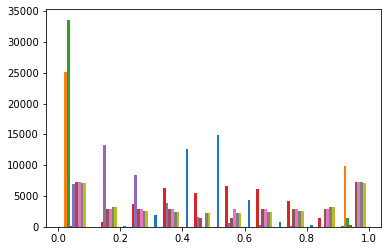

In [8]:
print(np.min(dataset), np.max(dataset))
plt.hist(dataset)

In [9]:
past_history = 96
future_target = 4
STEP = 1


x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset, prod_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset, cons_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [19]:
# https://stackoverflow.com/questions/47596703/multiple-outputs-for-multi-step-ahead-time-series-prediction-with-keras-lstm


inputs = Input(shape=(past_history,len(features_considered)))
conv1 = Conv1D(32, kernel_size=4, activation='relu')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)


# # conv2 = Conv1D(64, kernel_size=4, activation='relu')(pool1)
# # pool2 = MaxPooling1D(pool_size=2)(conv2)
m = Dropout(0.2)(pool1)
m = LSTM(256,  return_sequences=False)(m)
# m = LSTM(256)(m)
#m = Dense(96, activation='tanh')(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=50,steps_per_epoch=100)

test_scores = m.evaluate(x_val, [y1_val, y2_val], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/50
100/100 [==============================] - 4s 31ms/step - loss: 0.0437 - dense_2_loss: 0.0237 - dense_3_loss: 0.0200
Epoch 2/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0259 - dense_2_loss: 0.0129 - dense_3_loss: 0.0130
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0232 - dense_2_loss: 0.0108 - dense_3_loss: 0.0124
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0215 - dense_2_loss: 0.0099 - dense_3_loss: 0.0116
Epoch 5/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0202 - dense_2_loss: 0.0091 - dense_3_loss: 0.0111
Epoch 6/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0196 - dense_2_loss: 0.0088 - dense_3_loss: 0.0108
Epoch 7/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0185 - dense_2_loss: 0.0083 - dense_3_loss: 0.0102
Epoch 8/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0175 - dense_2_loss: 0.0078

In [20]:
pred = m.predict(x_val)

In [21]:
pred

[array([[0.10425007, 0.1078341 , 0.10406514, 0.10254296],
        [0.10419437, 0.10745588, 0.10271979, 0.09963109],
        [0.10349637, 0.10649219, 0.10087794, 0.09736031],
        ...,
        [0.33992967, 0.3256854 , 0.3204934 , 0.3337593 ],
        [0.3401441 , 0.32521453, 0.32114145, 0.33376098],
        [0.3398115 , 0.32378912, 0.31842402, 0.33192897]], dtype=float32),
 array([[0.13593908, 0.13991296, 0.13590617, 0.13454518],
        [0.13759191, 0.14119552, 0.13631308, 0.13332613],
        [0.13814087, 0.1414279 , 0.13574256, 0.13226512],
        ...,
        [0.06184237, 0.04729227, 0.04250973, 0.05542958],
        [0.06190163, 0.04669692, 0.04302447, 0.05529659],
        [0.05897469, 0.04272815, 0.0377595 , 0.05088326]], dtype=float32)]

In [22]:
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+4]])
actual = np.array(actual)

<ipython-input-22-8ffa35d5544e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


In [23]:
rmse(pred[0][:-4],actual[:-4])

array([[0.36067667],
       [0.36083381],
       [0.36106689],
       [0.36136449]])

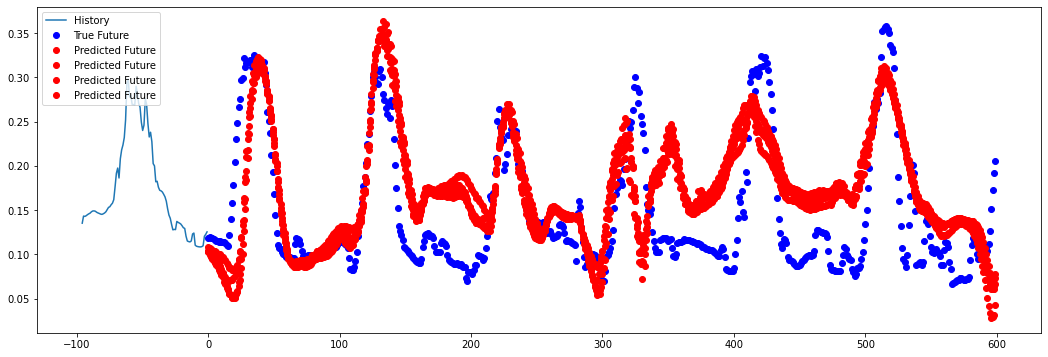

In [24]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val[:600], pred[0][:600])

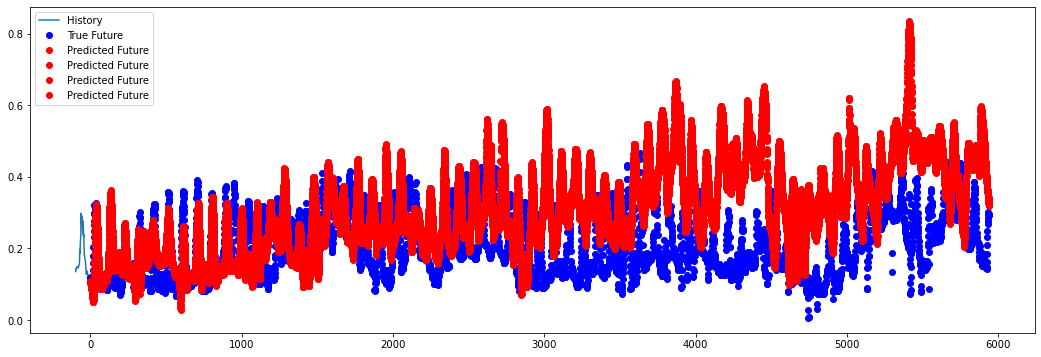

In [25]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val, pred[0])

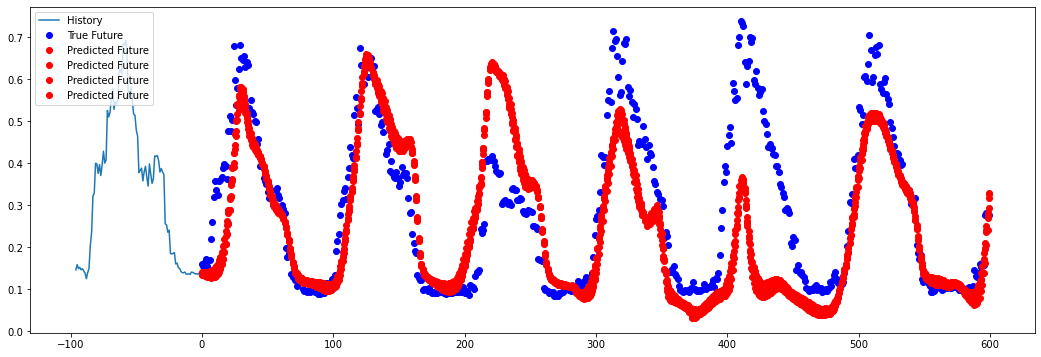

In [26]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val[:600], pred[1][:600])

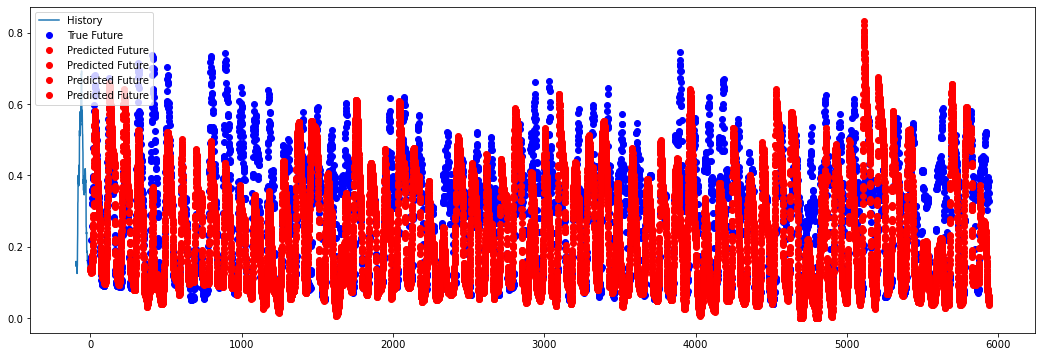

In [27]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val, pred[1])